In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnnboundary import *

In [3]:
import torch

# MOTIF

In [4]:
dataset = MotifDataset(seed=12345)

In [5]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=6,
                      num_layers=3)
model.load_state_dict(torch.load('ckpts/motif.pt'))

<All keys matched successfully>

In [6]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

/opt/homebrew/Caskroom/mambaforge/base/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/homebrew/Caskroom/mambaforge/base/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.9584597945213318,
 'cm': array([[2622,   27,  194,    0],
        [  12, 2898,    0,   44],
        [ 199,    1, 2732,    0],
        [   0,    2,    0, 2800]]),
 'f1': {'house': 0.9238900542259216,
  'house_x': 0.9853790998458862,
  'comp_4': 0.9327415227890015,
  'comp_5': 0.9918526411056519}}

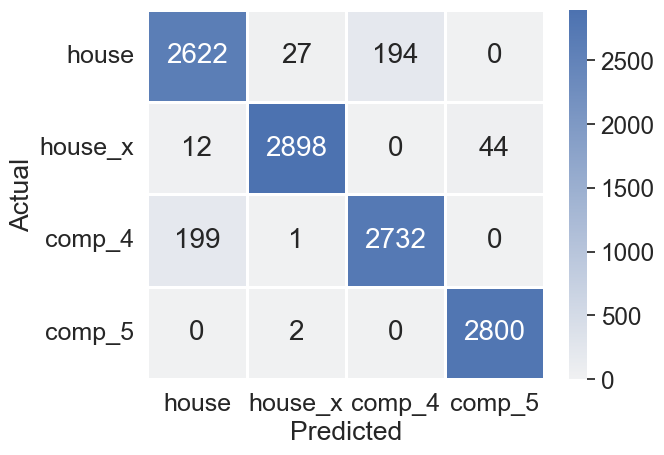

In [8]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [9]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

/opt/homebrew/Caskroom/mambaforge/base/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


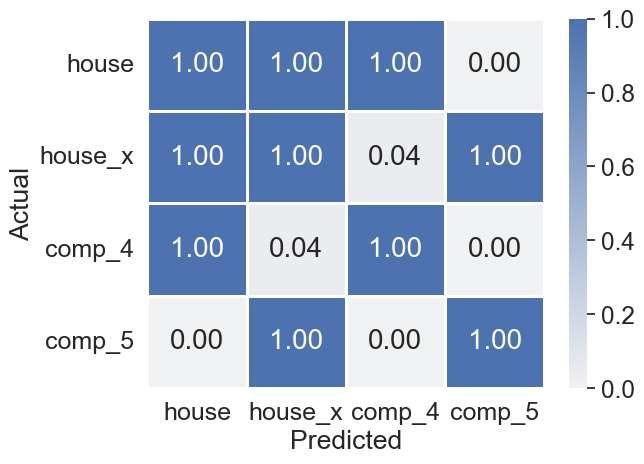

In [10]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')

In [11]:
trainer = {}
sampler = {}

# 0 & 1

In [18]:
cls_1, cls_2 = 0, 1
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=2
        ), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [19]:
cls_1, cls_2 = 0, 1
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=24 m=36
logits=[3.361572742462158, 3.646533727645874, -5.2208476066589355, -8.018879890441895]
probs=[0.42920130491256714, 0.5707133412361145, 8.04198716650717e-05, 4.899966825178126e-06]


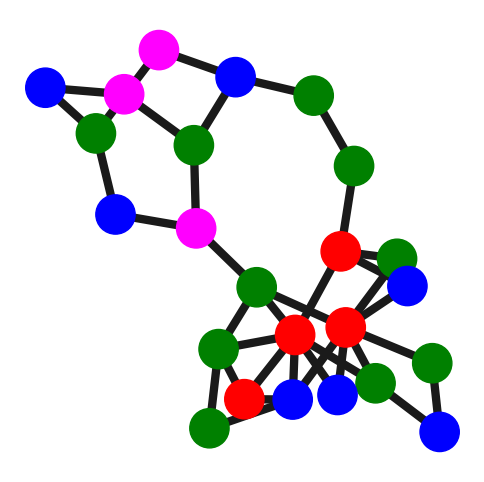

In [20]:
trainer[0, 1].evaluate(threshold=0.5, show=True)

# 0 & 2

In [12]:
cls_1, cls_2 = 0, 2
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=2
        ), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [13]:
cls_1, cls_2 = 0, 2
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=24 m=39
logits=[5.531874179840088, -1.523653268814087, 5.7074456214904785, -16.42693328857422]
probs=[0.45604005455970764, 0.00039339266368187964, 0.5435665249824524, 1.3256055975130465e-10]


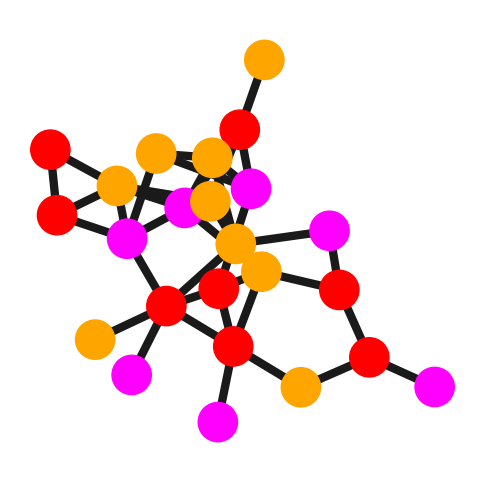

In [14]:
trainer[0, 2].evaluate(threshold=0.5, show=True)

# 1 & 3

In [28]:
cls_1, cls_2 = 1, 3
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=2),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1)
)

In [29]:
cls_1, cls_2 = 1, 3
trainer[cls_1, cls_2].train(
    iterations=10000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=60,
    w_budget_init=1,
    w_budget_inc=1.15,
    w_budget_dec=0.98,
    k_samples=16
)

  0%|          | 0/10000 [00:00<?, ?it/s]

True

n=20 m=52
logits=[-4.59466552734375, 23.773210525512695, -46.31407165527344, 24.834630966186523]
probs=[1.2302275355109e-13, 0.25703808665275574, 9.364331243000782e-32, 0.7429618835449219]


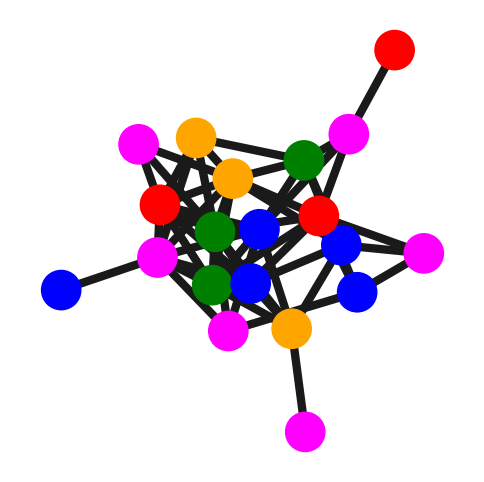

In [30]:
trainer[1, 3].evaluate(threshold=0.5, show=True)